In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

In [ ]:
from autoencodix.utils.example_data import (
    EXAMPLE_MULTI_BULK,
    EXAMPLE_MULTI_SC,
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
raw_sc = EXAMPLE_MULTI_SC

In [ ]:
EXAMPLE_PROCESSED_DATA.train.metadata

In [ ]:
import autoencodix as acx
from autoencodix.configs.default_config import DefaultConfig

In [ ]:
vanillix = acx.Vanillix(config=DefaultConfig(epochs=20, learning_rate=0.005,n_layers=1, latent_dim=2, checkpoint_interval=5), data=processed_data)
vanillix.run()
vanillix.show_result()

In [ ]:
vanillix._visualizer.show_latent_space(result=vanillix.result,plot_type="2D-scatter", param=["cluster"])

In [ ]:
vanillix.result.model

## Ontix

In [1]:
import autoencodix as acx
from autoencodix.configs.default_config import DefaultConfig
from autoencodix.configs.ontix_config import OntixConfig

from autoencodix.utils.example_data import (
    EXAMPLE_PROCESSED_DATA,
)

# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

ont_lvl1 = dict()
ont_lvl2 = dict()

ont_lvl1["pwy-1"] = ["sub-pwy-1", "sub-pwy-2"]
ont_lvl1["pwy-2"] = ["sub-pwy-2"]
ont_lvl1["pwy-3"] = ["sub-pwy-1", "sub-pwy-3"]
# first third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-1"] = processed_data.train.feature_ids[: int(len(processed_data.train.feature_ids) / 3)]
# second third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-2"] = processed_data.train.feature_ids[
	int(len(processed_data.train.feature_ids) / 3) : int(2 * len(processed_data.train.feature_ids) / 3)
]
# last third of feature ids in processed_data.train.feature_ids
ont_lvl2["sub-pwy-3"] = processed_data.train.feature_ids[
	int(2 * len(processed_data.train.feature_ids) / 3) : int(len(processed_data.train.feature_ids))
]

# ont_lvl2["sub-pwy-1"] = ["gene-1", "gene-2"]
# ont_lvl2["sub-pwy-2"] = ["gene-3", "gene-4"]
# ont_lvl2["sub-pwy-3"] = ["gene-2", "gene-6"]

ontology_tuple = ( ont_lvl1, ont_lvl2 )


In [3]:
# Write each dictionary in ontology_tuple to a separate text file
for i, ont_dict in enumerate(ontology_tuple):
	file_name = f"ontology_level_{i+1}.txt"
	with open(file_name, "w") as f:
		for key, values in ont_dict.items():
			for value in values:
				f.write(f"{value}\t{key}\n")
print("Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt")

Ontology dictionaries written to ontology_level_1.txt and ontology_level_2.txt


In [4]:
ont_files = ["ontology_level_1.txt", "ontology_level_2.txt"]

In [6]:
ontix = acx.Ontix(ontologies=ont_files, sep="\t", config=OntixConfig(epochs=5, learning_rate=0.005,n_layers=1), data=processed_data)
# ontix = acx.Ontix(ontologies=ontology_tuple, config=DefaultConfig(epochs=500, learning_rate=0.005,n_layers=1), user_data=processed_data)

In [7]:
ontix.run()

preprocessing
Ontix checks:
All possible feature names length: 30
Feature order length: 30
Feature names without filtering: 30
Mask layer 0 with shape torch.Size([3, 3]) and 5.0 connections
Mask layer 1 with shape torch.Size([30, 3]) and 30.0 connections
Latent Dim: 3
Epoch 1 - Train Loss: 857579.0312
Sub-losses: recon_loss: 857578.9453, var_loss: 0.0575, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 121135.9106
Sub-losses: recon_loss: 121135.8945, var_loss: 0.0135, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 841181.9258
Sub-losses: recon_loss: 841167.6562, var_loss: 14.2766, anneal_factor: 0.0025, effective_beta_factor: 0.0025
Epoch 2 - Valid Loss: 117598.0068
Sub-losses: recon_loss: 117593.4565, var_loss: 4.5492, anneal_factor: 0.0025, effective_beta_factor: 0.0025
Epoch 3 - Train Loss: 813870.1562
Sub-losses: recon_loss: 812349.8789, var_loss: 1520.2780, anneal_factor: 0.1192, effective_beta_factor: 0.1192
Epoch 3 - Valid L

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: OntixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x33956a950>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3392d0b20>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x3392d0ee0>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 201 × 3
    uns: 'var_names'
final_reconstruction: <au

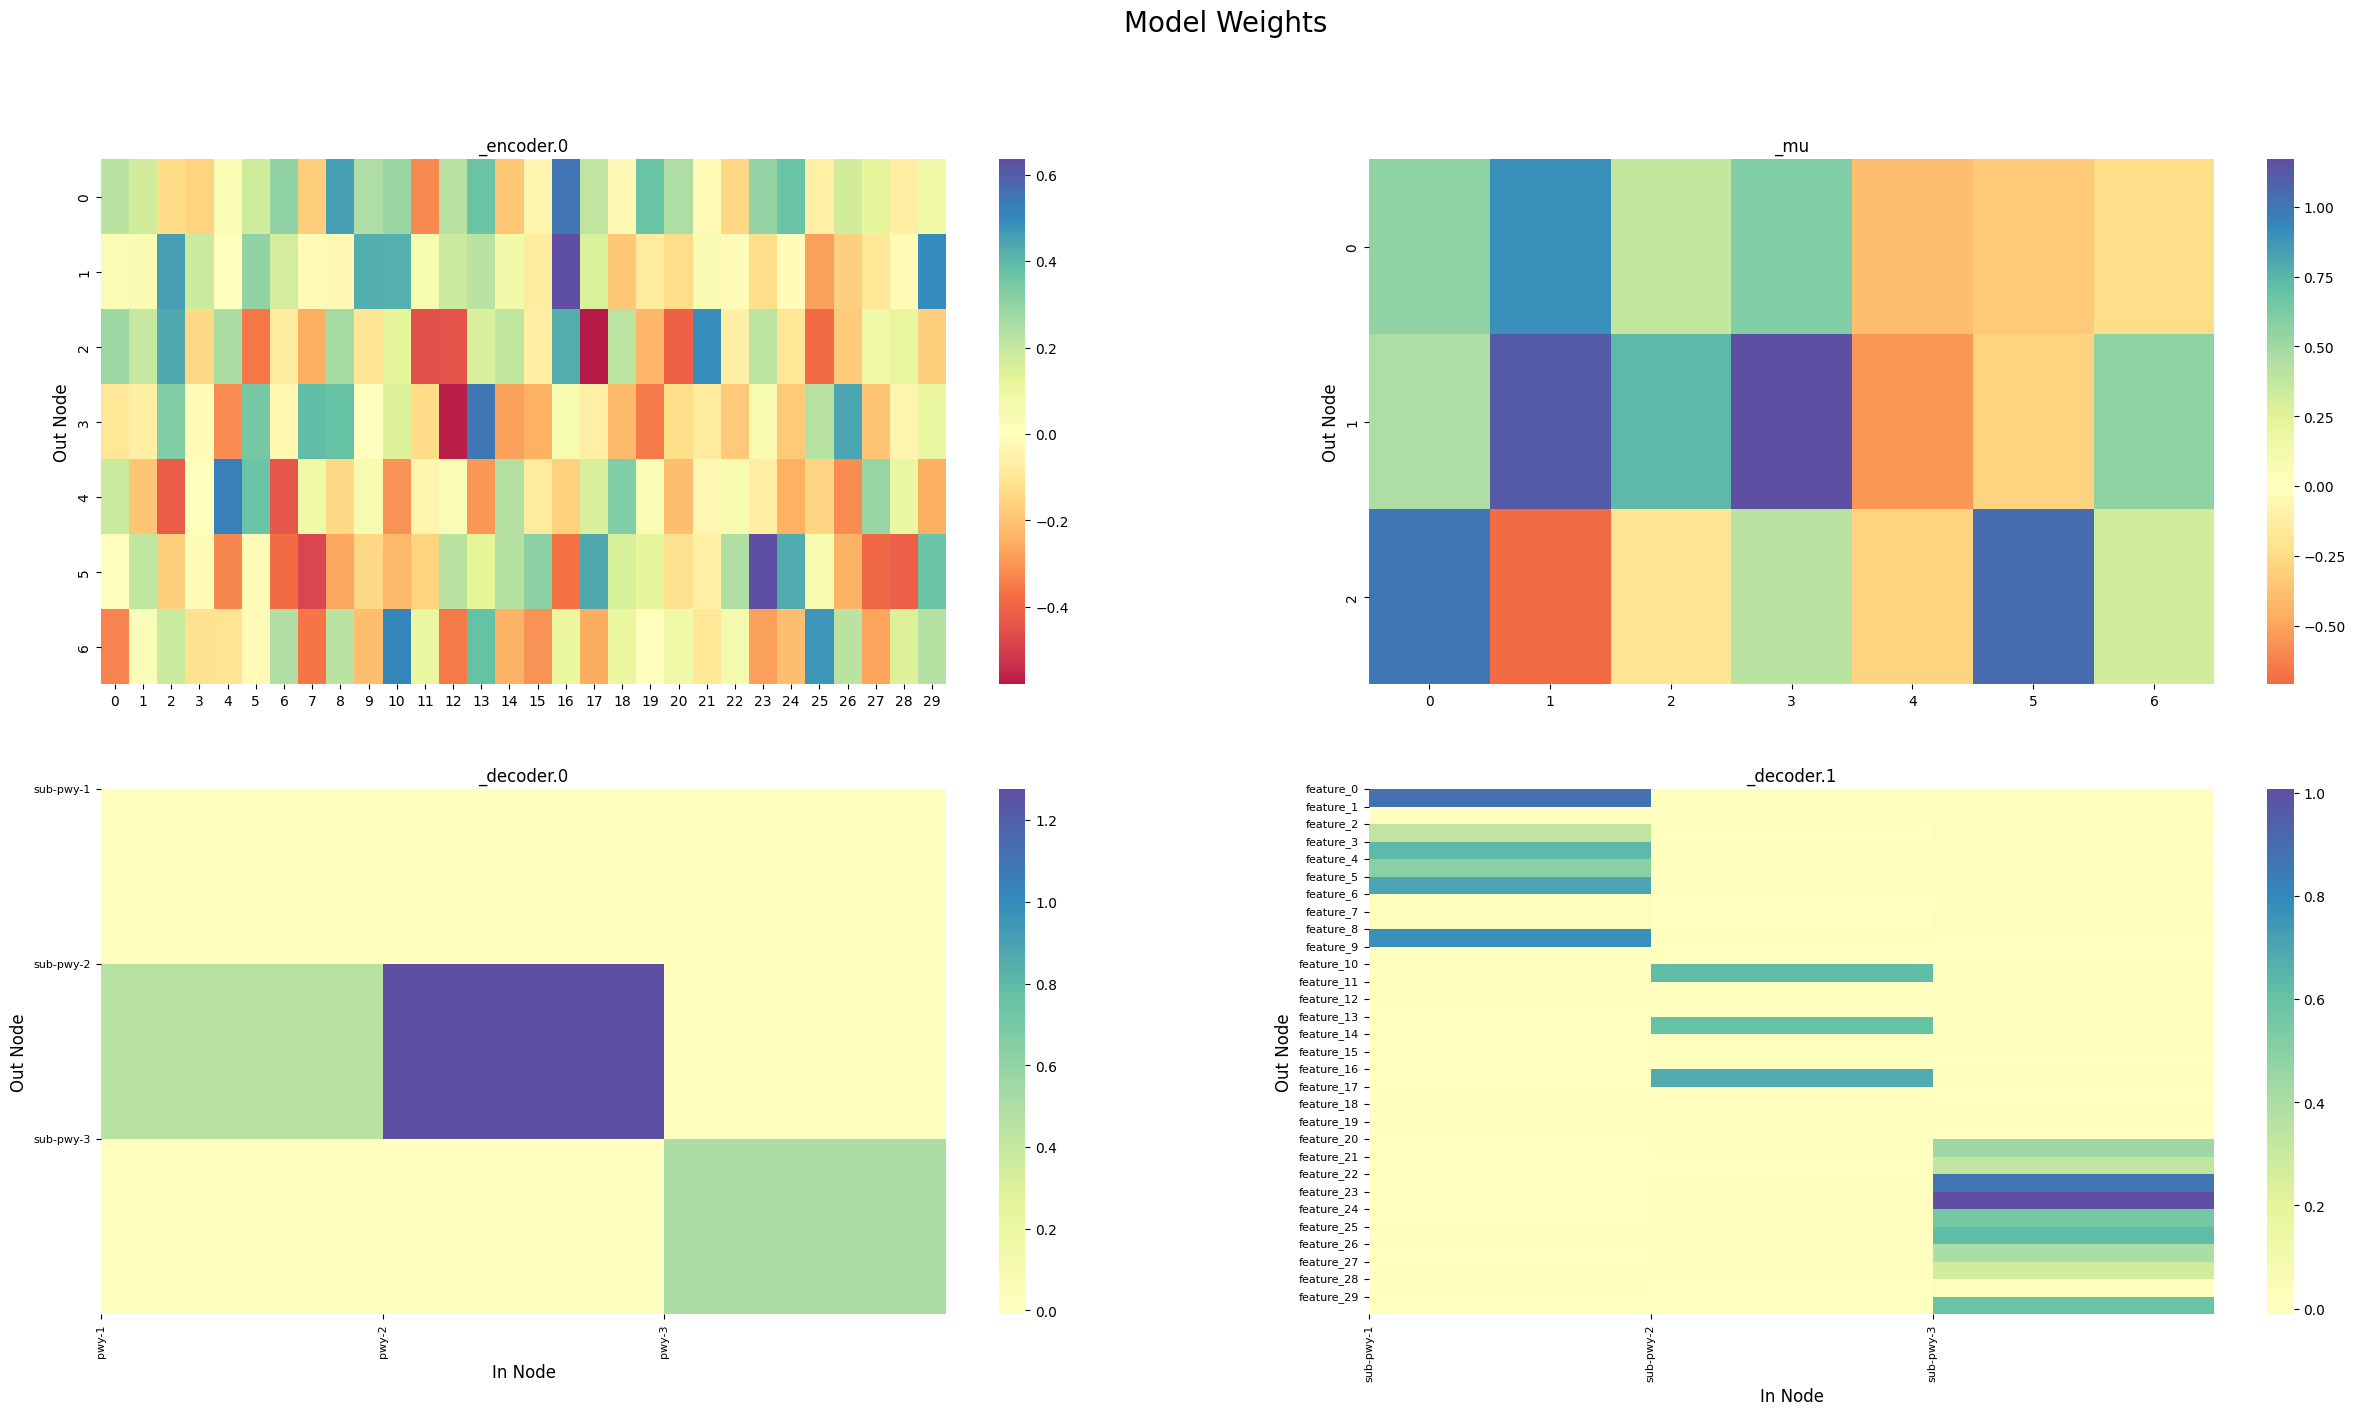

In [8]:
ontix._visualizer.show_weights()

Creating plots ...


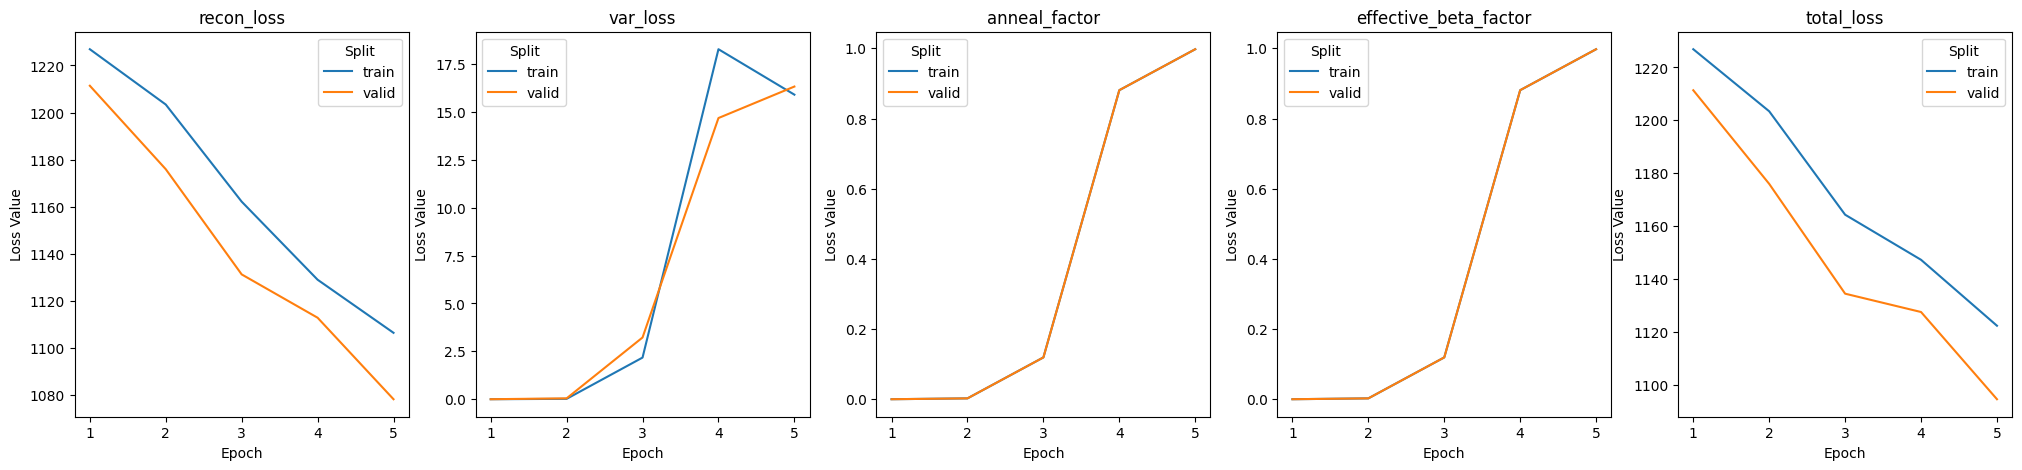

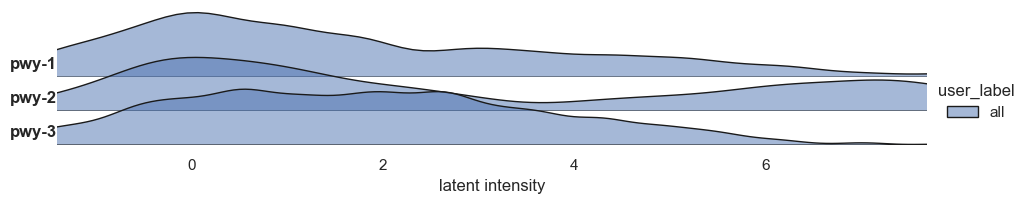

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


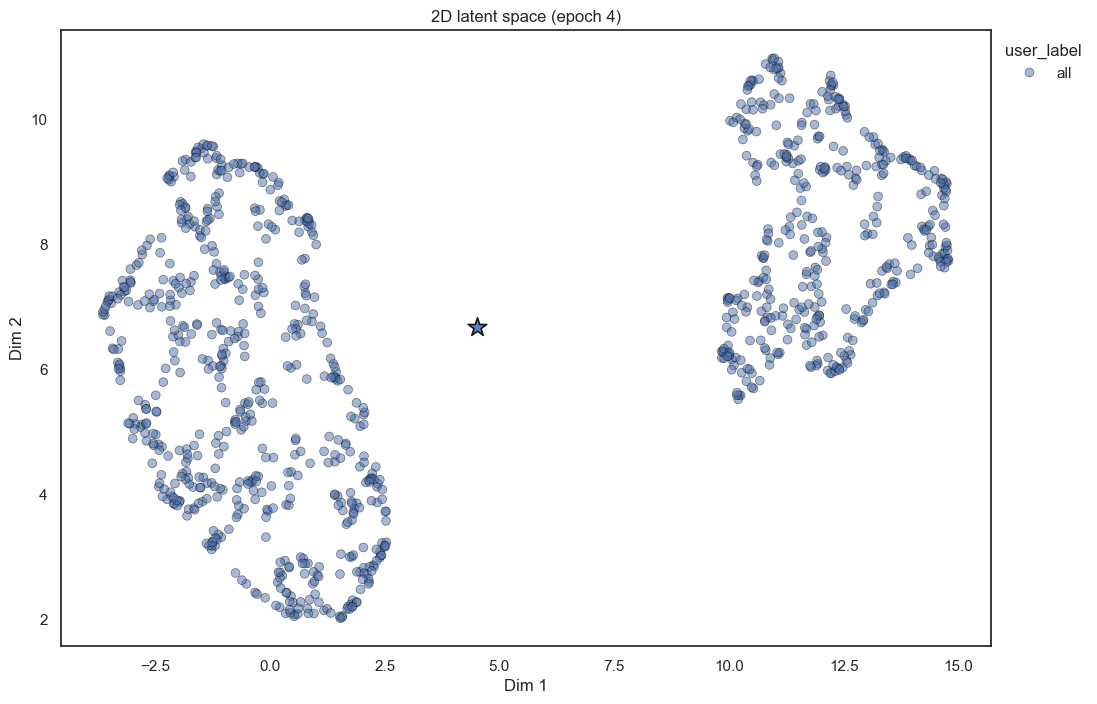

In [9]:
ontix.show_result()

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


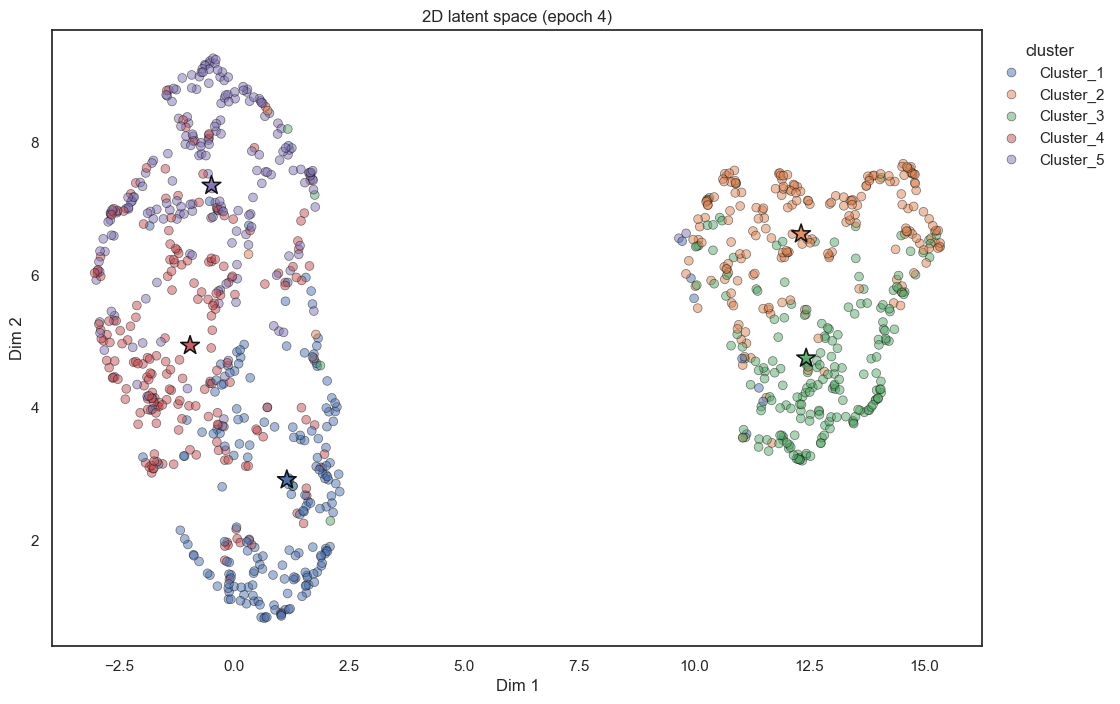

In [10]:
ontix._visualizer.show_latent_space(result=ontix.result,plot_type="2D-scatter", param=["cluster"])

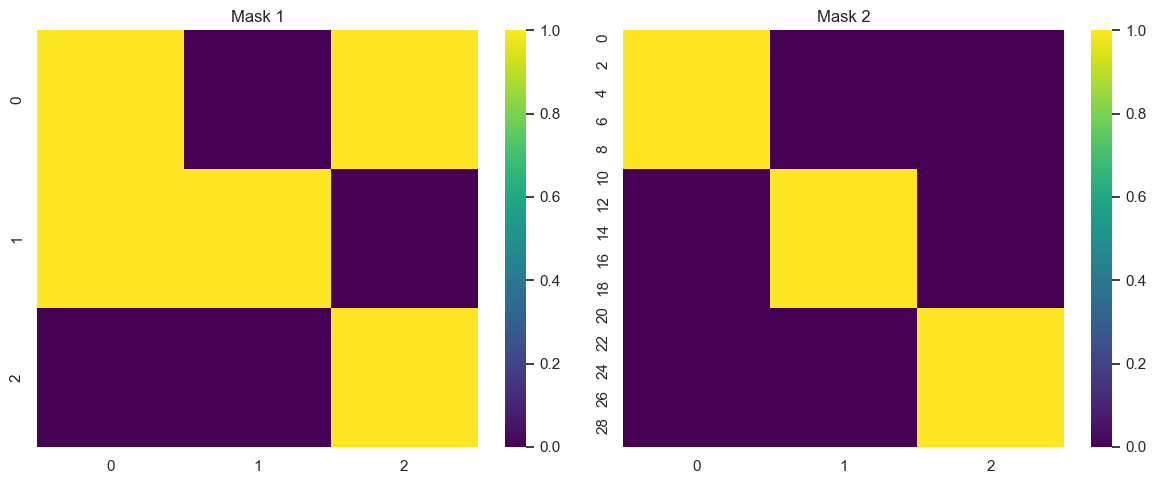

In [11]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

masks = ontix.result.model.masks

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, mask in enumerate(masks):
	sns.heatmap(np.array(mask), ax=axes[i], cmap="viridis")
	axes[i].set_title(f"Mask {i+1}")
plt.tight_layout()
plt.show()